# Import of all pictures into a Pandas Dataframe

Import of libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh
from sklearn.model_selection import train_test_split
import cv2

## Data preparation
First count the number of pictures. Then put the paths for all pictures with the class and patient_id in a dataframe entry.

In [2]:
base_path = "data"
folder = os.listdir(base_path)
total_images = 0

#finding the number of total images
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = os.path.join(base_path, patient_id )
        class_path = os.path.join(patient_path, str(c))
        subfiles = os.listdir(class_path)
        total_images += len(subfiles)

#DATAFRAME
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "class"])
k = 0
for n in range(len(folder)):
    #if folder[n] == 'IDC_regular_ps50_idx5':
    #    continue
    patient_id = folder[n]
    patient_path = os.path.join(base_path, patient_id )
    for c in [0,1]:
        class_path = os.path.join(patient_path, str(c))
        subfiles = os.listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            if image_path[-18:] == '.ipynb_checkpoints':
                continue
            data.iloc[k]["path"] = os.path.join(class_path, image_path)
            data.iloc[k]["class"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

In [3]:
#print(data.tail)
#print(data.loc[11124,'path'])
#print(data.loc[11124])
#plt.imshow(plt.imread(data.loc[11124,'path']))

In [4]:
#Creating a dataframe for each patient
for i in folder:
    if folder[n] == 'IDC_regular_ps50_idx5':
        continue
    df = data[data['patient_id'] == i]
    exec(f'data{i} = df')

## Creating pandas dataframe for storing extracted paramters
Make the dataframe for storing extracted parameters. Also define some key variables and functions.

In [18]:
parameters_df = pd.DataFrame(columns = ['red', 'green', 'blue', 'gray', 'edges', 'group'])
number_of_pix = 50*50

def split_path(path):
    path_elements = path.split('/')
    patient = path_elements[1]
    group = path_elements[2]
    return patient, group

def extract_color_channels(path):
    img = io.imread(path)
    imgGray = rgb2gray(img)
    red = sum(sum(img[:,:,0]))/number_of_pix
    green = sum(sum(img[:,:,1]))/number_of_pix
    blue = sum(sum(img[:,:,2]))/number_of_pix
    gray = sum(sum(imgGray[:,:]))/number_of_pix
    return red, green, blue, gray

def extract_number_edges(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img,180,250)
    num_edges = len(edges[np.where(edges == 255)])
    return num_edges

## Color channels and edge extraction
Using the Canny-edge detector to detect edge pixels, and then saving the number of edge pixels as a parameter.

In [22]:
st = time.time()
patients = set()
i = 0
while True:
    #if data.loc[i,'path'][-18:] == '.ipynb_checkpoints':
    #    continue
    patient, group = split_path(data.loc[i,'path'])
    patients.add(patient)
    if len(patients) == 31:
        print(f'Ferdig')
        break
    red, blue, green, gray = extract_color_channels(data.loc[i,'path'])
    edge_pieces = extract_number_edges(data.loc[i,'path'])
    parameters_df.loc[data.loc[i,'path']] = [red,green,blue,gray,edge_pieces,group]
    i += 1

patients.pop()

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
print(f'Number of rows: {len(parameters_df)}')
print(parameters_df.head())

Ferdig
Execution time: 126.20435285568237 seconds
Number of rows: 28061
                                                   red   green    blue  \
data/12910/0/12910_idx5_x3001_y701_class0.png   2.8792  2.7112  2.8076   
data/12910/0/12910_idx5_x1501_y401_class0.png   2.7392  2.7464  2.0908   
data/12910/0/12910_idx5_x2251_y1101_class0.png  1.1296  2.6620  2.2704   
data/12910/0/12910_idx5_x2551_y1151_class0.png  1.9812  2.8940  2.2452   
data/12910/0/12910_idx5_x2001_y101_class0.png   2.8660  3.0032  2.5404   

                                                    gray  edges group  
data/12910/0/12910_idx5_x3001_y701_class0.png   0.755730     83     0  
data/12910/0/12910_idx5_x1501_y401_class0.png   0.483340    350     0  
data/12910/0/12910_idx5_x2251_y1101_class0.png  0.799321     14     0  
data/12910/0/12910_idx5_x2551_y1151_class0.png  0.824825      0     0  
data/12910/0/12910_idx5_x2001_y101_class0.png   0.675241    187     0  


## Trying blob detection

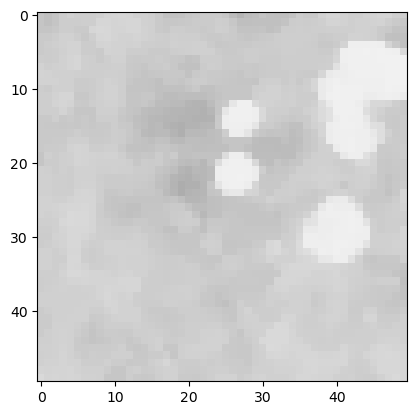

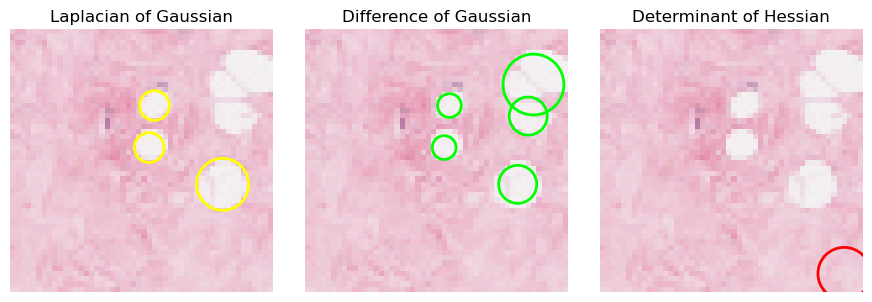

In [73]:
img = io.imread(data.loc[1000,'path'])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

image_gray = cv2.medianBlur(gray, 3)
plt.imshow(cv2.cvtColor(image_gray, cv2.COLOR_BGR2RGB))
plt.show()

blobs_log = blob_log(image_gray, min_sigma=2, max_sigma=8, num_sigma=5, threshold=.08)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.05)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=5, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(img)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

In [23]:
#Export dataframe to JSON file
parameters_df.to_json(r'parameters_df.json', orient='index')

In [24]:
#Import dataframe from JSON file
jsonStr = "parameters_df.json"
imported_df = pd.read_json(jsonStr, orient ='index')
print(imported_df.tail)

<bound method NDFrame.tail of                                                    red   green    blue  \
data/12910/0/12910_idx5_x3001_y701_class0.png   2.8792  2.7112  2.8076   
data/12910/0/12910_idx5_x1501_y401_class0.png   2.7392  2.7464  2.0908   
data/12910/0/12910_idx5_x2251_y1101_class0.png  1.1296  2.6620  2.2704   
data/12910/0/12910_idx5_x2551_y1151_class0.png  1.9812  2.8940  2.2452   
data/12910/0/12910_idx5_x2001_y101_class0.png   2.8660  3.0032  2.5404   
...                                                ...     ...     ...   
data/10295/1/10295_idx5_x1451_y1751_class1.png  2.4984  2.3112  2.5208   
data/10295/1/10295_idx5_x1251_y1751_class1.png  2.3984  2.4340  2.4816   
data/10295/1/10295_idx5_x1501_y1351_class1.png  2.3928  2.5132  2.6456   
data/10295/1/10295_idx5_x1501_y1601_class1.png  2.7404  2.5352  2.3744   
data/10295/1/10295_idx5_x1251_y1851_class1.png  2.3600  2.9432  2.1736   

                                                    gray  edges  group  
data/129